# SwiFlowNet
It is a cutting-edge machine learning method that uses deep learning
neural networks to estimate optical flow. The Multiflow Deep Learning model[1] serves as its foundation.The model is tested on different activation functions and optimizers.Error metrics such as AEPE,AMSE & AE are used to evaluate the accuracy of optical flow. It calculates the optical flow using a middlebury data set ground truth for training. The model was created on Colab, and it evaluates the drive's directory to gain access to the directory containing the images and the source data for calculating optical flow.

# Directory Structure:-

dataset -> images -> alley_1 -> frame_000x.png

dataset -> flows -> alley_1 -> frame_000x.flo

The optical flow images generated are stored in the directory as follows:-

dataset -> Final_Scenes_Results -> Alley_1 -> Test -> x.png

dataset -> Final_Scenes_Results -> Alley_1 -> Train -> x.png



# Tensorflow and Tensorflow Addons:-

Tensorflow version 2.13.0 and Tensorflow Addons version 0.21.0 have been used and are working perfectly on colab.

In [ ]:
!pip install tensorflow_addons

In [ ]:
!pip install tensorflow==2.13.0

In [ ]:
# Include all required libraries.
%tensorflow_version 2.x
import os
import re
import sys
import time
import uuid
import numpy as np
import pandas as pd
from PIL import Image
from scipy import misc
import tensorflow as tf
import matplotlib.colors as cl
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.layers import CorrelationCost
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, InputLayer, Concatenate
from tensorflow.keras.layers import Dropout

In [ ]:
# Connecting Google Colab to the Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Reading .csv for input 3-image optical flow and ground-truth optical flow
df= pd.read_csv('/content/gdrive/My Drive/alley1_train.csv')

In [ ]:
print(df)
print("Length of Dataframe is: ",len(df))

In [ ]:
# Coverting dataframe column to list to pass it for mapping in tf.dataset
img_1_list = df['img1'].tolist()
img_2_list = df['img2'].tolist()
img_3_list = df['img3'].tolist()
flo_list = df['flow'].tolist()

In [ ]:
# Reading image frames from directory
images_dir="/content/gdrive/My Drive/dataset/images/"

def readImage(img_1,img_2,img_3):

    img1 = tf.io.read_file(images_dir+img_1.decode("utf-8"))
    img1 = tf.image.decode_png(img1, channels=3)

    img2 = tf.io.read_file(images_dir+img_2.decode("utf-8"))
    img2 = tf.image.decode_png(img2, channels=3)

    img3 = tf.io.read_file(images_dir+img_3.decode("utf-8"))
    img3 = tf.image.decode_png(img3, channels=3)

    return img1, img2, img3

In [ ]:
# Reading Flow from the directory
flow_dir="/content/gdrive/My Drive/dataset/flows/"
def readFlow(name):
    if name.endswith('.pfm') or name.endswith('.PFM'):
        return readPFM(name)[0][:,:,0:2]

    f = open(name, 'rb')

    header = f.read(4)
    if header.decode("utf-8") != 'PIEH':
        raise Exception('Flow file header does not contain PIEH')

    width = np.fromfile(f, np.int32, 1).squeeze()
    height = np.fromfile(f, np.int32, 1).squeeze()

    flow = np.fromfile(f, np.float32, width * height * 2).reshape((height, width, 2))

    return flow.astype(np.float32)

In [ ]:
def map_function(img_1,img_2,img_3,flow):
    img1, img2, img3 = readImage(img_1,img_2,img_3)
    flow = readFlow(flow_dir+flow.decode("utf-8"))
    return tf.dtypes.cast(img1, tf.float32), tf.dtypes.cast(img2, tf.float32), tf.dtypes.cast(img3, tf.float32) , tf.dtypes.cast(flow, tf.float32)

# Batch Size:-
The batch size used here, determines how many values/trials will be used in a single iteration.Variying batch size leads to better/poor training, depending upon hardware.

In [ ]:
batch_size = 6
dataset = tf.data.Dataset.from_tensor_slices((img_1_list,img_2_list,img_3_list,flo_list))
dataset = dataset.map(lambda item1, item2, item3, item4: tf.numpy_function(
          map_function, [item1, item2, item3, item4], [tf.float32, tf.float32, tf.float32,tf.float32]),num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=4)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)


In [ ]:
#Displays the number of elements in the dataset
num_elements = tf.data.experimental.cardinality(dataset).numpy()
print("Number of elements in tf.data.Dataset is :",num_elements)

In [ ]:
def crop_like(input, target):
    if input.shape[1:3] == target.shape[1:3]:
        return input
    else:
        return input[:, :target.shape[1],:target.shape[2],:]

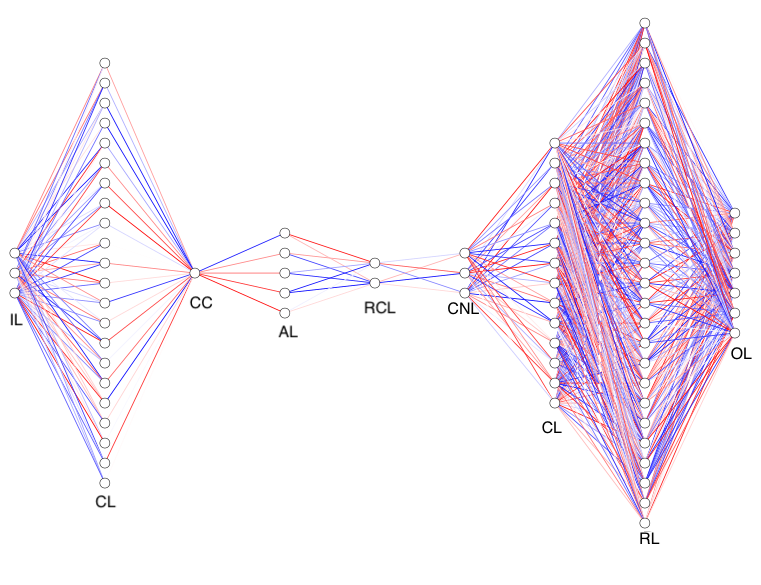

The Neural Network Architecture has been tested out with different activation functions such as Swish,Sigmoid.

In [ ]:
class SwiFlowNet(tf.keras.Model):
  # Layer declaration
  def __init__(self):
    super(SwiFlowNet, self).__init__()
    self.i1= InputLayer(input_shape=(436,1024,3))
    self.i2= InputLayer(input_shape=(436,1024,3))
    self.i3= InputLayer(input_shape=(436,1024,3))

    #Input path-1
    self.conva_1= Conv2D(64,7,strides=2,padding='same') #Convolution layer
    self.conva_1_act = tf.keras.layers.Activation(tf.keras.activations.swish)
    self.conva_2= Conv2D(128,5,strides=2,padding='same')
    self.conva_2_act = tf.keras.layers.Activation(tf.keras.activations.swish)
    self.conva_3= Conv2D(256,5,strides=2,padding='same')
    self.conva_3_act = tf.keras.layers.Activation(tf.keras.activations.swish)

    #Input path-2
    self.convb_1= Conv2D(64,7,strides=2,padding='same')
    self.convb_1_act =tf.keras.layers.Activation(tf.keras.activations.swish)
    self.convb_2= Conv2D(128,5,strides=2,padding='same')
    self.convb_2_act =tf.keras.layers.Activation(tf.keras.activations.swish)
    self.convb_3= Conv2D(256,5,strides=2,padding='same')
    self.convb_3_act =tf.keras.layers.Activation(tf.keras.activations.swish)

    #Input path-3
    self.convc_1= Conv2D(64,7,strides=2,padding='same')
    self.convc_1_act =tf.keras.layers.Activation(tf.keras.activations.swish)
    self.convc_2= Conv2D(128,5,strides=2,padding='same')
    self.convc_2_act =tf.keras.layers.Activation(tf.keras.activations.swish)
    self.convc_3= Conv2D(256,5,strides=2,padding='same')
    self.convc_3_act =tf.keras.layers.Activation(tf.keras.activations.swish)

    #Correalation layer
    self.cc = CorrelationCost(1,40,1,2,40,data_format='channels_last')

    self.cr_1_act= tf.keras.layers.Activation(tf.keras.activations.swish)
    self.conva_redir= Conv2D(32,1,strides=1) #Convolution redir for features for CR1
    self.conva_redir_act =tf.keras.layers.Activation(tf.keras.activations.swish)
    self.vol_1= Concatenate(axis=3)

    self.cr_2_act= tf.keras.layers.Activation(tf.keras.activations.swish)
    self.convb_redir= Conv2D(32,1,strides=1) #Convolution redir for features for CR2
    self.convb_redir_act =tf.keras.layers.Activation(tf.keras.activations.swish)
    self.vol_2 = Concatenate(axis=3)

    #Passing CR1,CR2  through convolution layers
    self.conv_v1= Conv2D(256,5,strides=1,padding='same')
    self.conv_v1_act =tf.keras.layers.Activation(tf.keras.activations.swish)
    self.conv_v2= Conv2D(256,5,strides=1,padding='same')
    self.conv_v2_act =tf.keras.layers.Activation(tf.keras.activations.swish)

    #Correlation between volumes
    self.cr_3_act= tf.keras.layers.Activation(tf.keras.activations.swish)
    self.conv_v1_redir= Conv2D(32,1,strides=1) #Convolution redir for features for CR3
    self.conv_v1_redir_act = tf.keras.layers.Activation(tf.keras.activations.swish)
    self.vol_3= Concatenate(axis=3)

    #Single convolution stream
    self.conv3_1= Conv2D(256,3,strides=1,padding='same')
    self.conv3_1_act= tf.keras.layers.Activation(tf.keras.activations.swish)
    self.conv4= Conv2D(512,3,strides=2,padding='same')
    self.conv4_act= tf.keras.layers.Activation(tf.keras.activations.swish)
    self.conv4_1= Conv2D(512,3,strides=1,padding='same')
    self.conv4_1_act=tf.keras.layers.Activation(tf.keras.activations.swish)
    self.conv5= Conv2D(512,3,strides=2,padding='same')
    self.conv5_act= tf.keras.layers.Activation(tf.keras.activations.swish)
    self.conv5_1= Conv2D(512,3,strides=1,padding='same')
    self.conv5_1_act= tf.keras.layers.Activation(tf.keras.activations.swish)
    self.conv6= Conv2D(1024,3,strides=2,padding='same')
    self.conv6_act= tf.keras.layers.Activation(tf.keras.activations.swish)
    self.conv6_1= Conv2D(1024,3,strides=1,padding='same')
    self.conv6_1_act=tf.keras.layers.Activation(tf.keras.activations.swish)

    #Refinement network
    self.pf6= Conv2D(2,3,strides=1,padding='same')  #Predicted flow
    self.dc5= Conv2DTranspose(512,4,strides=2,padding='same')  #Transpose convolution
    self.dc5_act= tf.keras.layers.Activation(tf.keras.activations.swish)
    self.up_6to5= Conv2DTranspose(2,4,strides=2,padding='same') #Upsampled flow
    self.con_5= Concatenate(axis=3)  #Concating 3 streams conv-features,deconv,upsampled_flow

    self.pf5= Conv2D(2,3,strides=1,padding='same')
    self.dc4= Conv2DTranspose(256,4,strides=2,padding='same')
    self.dc4_act= tf.keras.layers.Activation(tf.keras.activations.swish)
    self.up_5to4= Conv2DTranspose(2,4,strides=2,padding='same')
    self.con_4= Concatenate(axis=3)

    self.pf4= Conv2D(2,3,strides=1,padding='same')
    self.dc3= Conv2DTranspose(128,4,strides=2,padding='same')
    self.dc3_act= tf.keras.layers.Activation(tf.keras.activations.swish)
    self.up_4to3= Conv2DTranspose(2,4,strides=2,padding='same')
    self.con_3= Concatenate(axis=3)

    self.pf3= Conv2D(2,3,strides=1,padding='same')
    self.dc2= Conv2DTranspose(128,4,strides=2,padding='same')
    self.dc2_act= tf.keras.layers.Activation(tf.keras.activations.swish)
    self.up_3to2= Conv2DTranspose(2,4,strides=2,padding='same')
    self.con_2=Concatenate(axis=3)

    self.pf2= Conv2D(2,3,strides=1,padding='same')
    self.dc1= Conv2DTranspose(64,4,strides=2,padding='same')
    self.dc1_act= tf.keras.layers.Activation(tf.keras.activations.swish)
    self.up_2to1= Conv2DTranspose(2,4,strides=2,padding='same')
    self.con_1=Concatenate(axis=3)

    self.pf1= Conv2D(2,3,strides=1,padding='same')

  #Layer Definition
  def call(self, input1,input2,input3,training=False):
    i_1=self.i1(input1)
    cona1=self.conva_1(i_1)
    cona1_act=self.conva_1_act(cona1)
    cona2=self.conva_2(cona1_act)
    cona2_act=self.conva_2_act(cona2)
    cona3=self.conva_3(cona2_act)
    cona3_act=self.conva_3_act(cona3)

    i_2=self.i2(input2)
    conb1=self.convb_1(i_2)
    conb1_act=self.convb_1_act(conb1)
    conb2=self.convb_2(conb1_act)
    conb2_act=self.convb_2_act(conb2)
    conb3=self.convb_3(conb2_act)
    conb3_act=self.convb_3_act(conb3)

    i_3=self.i3(input3)
    conc1=self.convc_1(i_3)
    conc1_act=self.convc_1_act(conc1)
    conc2=self.convc_2(conc1_act)
    conc2_act=self.convc_2_act(conc2)
    conc3=self.convc_3(conc2_act)
    conc3_act=self.convc_3_act(conc3)

    cc1=self.cc([cona3_act,conb3_act])
    cc1_act=self.cr_1_act(cc1)
    cona_r=self.conva_redir(cona3_act)
    cona_r_act=self.conva_redir_act(cona_r)
    v1=self.vol_1([cc1_act,cona_r_act])

    cc2=self.cc([conb3_act,conc3_act])
    cc2_act=self.cr_2_act(cc2)
    conb_r=self.convb_redir(conb3_act)
    conb_r_act=self.convb_redir_act(conb_r)
    v2=self.vol_2([cc2_act,conb_r_act])

    con_v1=self.conv_v1(v1)
    con_v1_act=self.conv_v1_act(con_v1)
    con_v2=self.conv_v2(v2)
    con_v2_act=self.conv_v2_act(con_v2)

    cc3=self.cc([con_v1_act,con_v2_act])
    cc3_act=self.cr_3_act(cc3)
    con_v1_r=self.conv_v1_redir(con_v1_act)
    con_v1_r_act=self.conv_v1_redir_act(con_v1_r)
    v3=self.vol_3([cc3_act,con_v1_r_act])

    con3_1=self.conv3_1(v3)
    con3_1_act=self.conv3_1_act(con3_1)
    con4=self.conv4(con3_1_act)
    con4_act=self.conv4_act(con4)
    con4_1=self.conv4_1(con4_act)
    con4_1_act=self.conv4_1_act(con4_1)
    con5=self.conv5(con4_1_act)
    con5_act=self.conv5_act(con5)
    con5_1=self.conv5_1(con5_act)
    con5_1_act=self.conv5_1_act(con5_1)
    con6=self.conv6(con5_1_act)
    con6_act=self.conv6_act(con6)
    con6_1=self.conv6_1(con6_act)
    con6_1_act=self.conv6_1_act(con6_1)

    pf_6=self.pf6(con6_1_act)
    dc_5=self.dc5(con6_1_act)
    dc_5_act=self.dc5_act(dc_5)
    ups_6to5=self.up_6to5(pf_6)
    concat5=self.con_5([con5_1_act,dc_5_act,ups_6to5])

    pf_5=self.pf5(concat5)
    dc_4=self.dc4(concat5)
    dc_4_act=self.dc4_act(dc_4)
    ups_5to4=self.up_5to4(pf_5)
    concat4=self.con_4([con4_1_act,dc_4_act,ups_5to4])

    pf_4=self.pf4(concat4)
    dc_3=self.dc3(concat4)
    dc_3_act=self.dc3_act(dc_3)
    dc_3_crop=crop_like(dc_3_act,con3_1_act)
    ups_4to3=self.up_4to3(pf_4)
    ups_4to3_crop=crop_like(ups_4to3,con3_1_act)
    concat3=self.con_3([con3_1_act,dc_3_crop,ups_4to3_crop])

    pf_3=self.pf3(concat3)
    dc_2=self.dc2(concat3)
    dc_2_act=self.dc2_act(dc_2)
    dc_2_crop=crop_like(dc_2_act,con_v1_act)
    ups_3to2=self.up_3to2(pf_3)
    ups_3to2_crop=crop_like(ups_3to2,con_v1_act)
    concat2=self.con_2([con_v1_act,dc_2_crop,ups_3to2_crop])

    pf_2=self.pf2(concat2)
    dc_1=self.dc1(concat2)
    dc_1_act=self.dc1_act(dc_1)
    dc_1_crop=crop_like(dc_1_act,cona2_act)
    ups_2to1=self.up_2to1(pf_2)
    ups_2to1_crop=crop_like(ups_2to1,cona2_act)
    concat1=self.con_1([cona2_act,dc_1_crop,ups_2to1_crop])

    pf_1=self.pf1(concat1)
    flow=tf.image.resize(pf_1,tf.stack([436,1024]),method='bilinear')
    return  {'flow': flow ,'predict_flow6': pf_6, 'predict_flow5': pf_5, 'predict_flow4': pf_4, 'predict_flow3': pf_3, 'predict_flow2': pf_2, 'predict_flow1': pf_1}


In [ ]:
model=SwiFlowNet()

In [ ]:
def a_epe(labels, predictions):
    squared_difference = tf.square(tf.subtract(predictions, labels))
    loss = tf.reduce_mean(squared_difference)
    loss = tf.sqrt(loss)
    loss = loss/len(df)
    return loss

In [ ]:
#Loss Function
def loss_function(real, pred):

  pred6 = pred['predict_flow6']
  size = [pred6.shape[1], pred6.shape[2]]
  df6 = tf.image.resize(real, tf.stack(size))
  epe6 = 0.32 * (a_epe(df6, pred6))

  pred5=pred['predict_flow5']
  size = [pred5.shape[1], pred5.shape[2]]
  df5 = tf.image.resize(real, tf.stack(size))
  epe5 = 0.32 * (a_epe(df5, pred5))

  pred4=pred['predict_flow4']
  size = [pred4.shape[1], pred4.shape[2]]
  df4 = tf.image.resize(real, tf.stack(size))
  epe4 = 0.32 * (a_epe(df4, pred4))

  pred3=pred['predict_flow3']
  size = [pred3.shape[1], pred3.shape[2]]
  df3 = tf.image.resize(real, tf.stack(size))
  epe3 = 0.32 * (a_epe(df3, pred3))

  pred2=pred['predict_flow2']
  size = [pred2.shape[1], pred2.shape[2]]
  df2 = tf.image.resize(real, tf.stack(size))
  epe2 = 0.32 * (a_epe(df2, pred2))

  pred1=pred['predict_flow1']
  size = [pred1.shape[1], pred1.shape[2]]
  df1 = tf.image.resize(real, tf.stack(size))
  epe1 = 0.64 * (a_epe(df1, pred1))

  loss = tf.math.add_n([epe6,epe5,epe4,epe3,epe2,epe1])

  return loss

Different Optimizers have been tested such as SGD,AdamW.

In [ ]:
optimizer= AdamW(weight_decay=0.0004, learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

In [ ]:
#Loading checkpoint weights
checkpoint_path = "/content/gdrive/My Drive/dataset/images/"
ckpt = tf.train.Checkpoint(model=model, optimizer = optimizer)
ckpt.restore(tf.train.latest_checkpoint(checkpoint_path))
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

In [ ]:
#Initialise based on checkpoints, initially 0
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
print("Start Epoch is",start_epoch)

In [ ]:
#Train function
def train_step(input1,input2,input3,flow):
    loss = 0
    i = 0
    with tf.GradientTape() as tape:
        predict = model(input1,input2,input3)
        loss = loss_function(flow,predict)

    trainable_variables = model.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [ ]:
# Train Function
EPOCHS =  10 # Set to run for the number of EPOCHS
loss_list =[]
start = time.time()
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img1,img2,img3,target)) in enumerate(dataset):
        batch_loss= train_step(img1,img2,img3,target)
        total_loss += batch_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    loss_list.append(total_loss)
    if epoch % 1 == 0:
        print("Saving model\n")
        ckpt_manager.save()
    GPU_Execution_Time = time.time() - start
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,total_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    print (f'Overall GPU Execution time: {GPU_Execution_Time:.2f} seconds')

# NVIDIA-SMI:-
Provides the details of the hardware being used and various other paramters such as Temperature, Power Usuage, Memory Usuage, the CUDA Version & the GPU being Used.

In [ ]:
!nvidia-smi

In [ ]:
# Plotting loss list
plt.plot(loss_list)
plt.imshow

In [ ]:
# Saving loss list
numpy_loss_history = np.array(loss_list)
np.savetxt("alley1.txt", numpy_loss_history, delimiter=",")

In [ ]:
def visualize_flow_train(flow,i):
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()
    plt.imsave("/content/gdrive/My Drive/dataset/Final_Scenes_Results/Alley_1/Train/"+str(i)+".png",img)
    return None

def visualize_flow_test(flow,i):
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()
    plt.imsave("/content/gdrive/My Drive/dataset/Final_Scenes_Results/Alley_1/Test/"+str(i)+".png",img)
    return None


def flow_error(tu, tv, u, v):
    UNKNOWN_FLOW_THRESH = 1e7
    smallflow = 0.0
    stu = tu[:]
    stv = tv[:]
    su = u[:]
    sv = v[:]
    idxUnknow = (abs(stu) > UNKNOWN_FLOW_THRESH) | (abs(stv) > UNKNOWN_FLOW_THRESH)
    stu[idxUnknow] = 0
    stv[idxUnknow] = 0
    su[idxUnknow] = 0
    sv[idxUnknow] = 0
    ind2_mask = np.logical_or(np.absolute(stu) > smallflow, np.absolute(stv) > smallflow)
    index_su = su[ind2_mask]
    index_sv = sv[ind2_mask]
    an = 1.0 / np.sqrt(index_su ** 2 + index_sv ** 2 + 1)
    un = index_su * an
    vn = index_sv * an
    index_stu = stu[ind2_mask]
    index_stv = stv[ind2_mask]
    tn = 1.0 / np.sqrt(index_stu ** 2 + index_stv ** 2 + 1)
    tun = index_stu * tn
    tvn = index_stv * tn
    epe = np.sqrt((stu - su) ** 2 + (stv - sv) ** 2)
    epe = epe[ind2_mask]
    mepe = np.mean(epe)
    return mepe


def mse(tu,tv,u,v):
    squared_difference_u = np.square(u - tu)
    squared_difference_v = np.square(v - tv)
    mse_u = np.mean(squared_difference_u)
    mse_v = np.mean(squared_difference_v)
    mse = (mse_u + mse_v) / 2
    return mse


def ae(tu,tv,u,v):
    dot_product = tu * u + tv * v + 1
    magnitude_product = np.sqrt((tu ** 2 + tv ** 2 + 1) * (u ** 2 + v ** 2 + 1))
    angular_error_rad = np.arccos(np.clip(dot_product / magnitude_product, -1, 1))
    angular_error_deg = np.degrees(angular_error_rad)
    return angular_error_deg

def flow_to_image(flow):
    UNKNOWN_FLOW_THRESH = 1e7
    u = flow[:, :, 0]
    v = flow[:, :, 1]
    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.
    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0
    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))
    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))
    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))
    print ("max flow: %.4f\nflow range:\nu = %.3f .. %.3f\nv = %.3f .. %.3f" % (maxrad, minu,maxu, minv, maxv))
    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)
    img = compute_color(u, v)
    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0
    return np.uint8(img)

def evaluate_flow(gt_flow, pred_flow):
    average_pe = flow_error(gt_flow[:, :, 0], gt_flow[:, :, 1], pred_flow[:, :, 0], pred_flow[:, :, 1])
    return average_pe


def evaluate_flow_mse(gt_flow, pred_flow):
    mse_pe = mse(gt_flow[:, :, 0], gt_flow[:, :, 1], pred_flow[:, :, 0], pred_flow[:, :, 1])
    return mse_pe

def evaluate_flow_ae(gt_flow, pred_flow):
    ae_pe = ae(gt_flow[:, :, 0], gt_flow[:, :, 1], pred_flow[:, :, 0], pred_flow[:, :, 1])
    return ae_pe

def compute_color(u, v):
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0
    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)
    rad = np.sqrt(u**2+v**2)
    a = np.arctan2(-v, -u) / np.pi
    fk = (a+1) / 2 * (ncols - 1) + 1
    k0 = np.floor(fk).astype(int)
    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0
    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1
        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)
        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))
    return img


def make_color_wheel():
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6
    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros([ncols, 3])
    col = 0
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255
    return colorwheel

In [ ]:
#Reading Train Dataframe
df= pd.read_csv('/content/gdrive/My Drive/alley1_train.csv')
img1_list = df['img1'].to_list()
img2_list = df['img2'].to_list()
img3_list = df['img3'].to_list()
flow_list = df['flow'].to_list()

In [ ]:
# Train inference function
def train_inference():

    imgpath = "/content/gdrive/My Drive/dataset/images/"
    avgepe = 0.0
    avgae = 0.0
    avgmse = 0.0

    for i in range(len(df)):
        img1 = tf.io.read_file(imgpath+img1_list[i])
        img1 = tf.image.decode_png(img1, channels=3)
        img1=tf.cast(img1,tf.float32)
        img1=tf.reshape(img1,(1,436,1024,3))

        img2 = tf.io.read_file(imgpath+img2_list[i])
        img2 = tf.image.decode_png(img2, channels=3)
        img2=tf.reshape(img2,(1,436,1024,3))
        img2=tf.cast(img2,tf.float32)

        img3 = tf.io.read_file(imgpath+img3_list[i])
        img3 = tf.image.decode_png(img3, channels=3)
        img3=tf.reshape(img3,(1,436,1024,3))
        img3=tf.cast(img3,tf.float32)

        start = time.time()
        flow_out=model(img1,img2, img3)
        print ('Time taken for 1 Prediction {} sec\n'.format(time.time() - start))
        test = flow_out['flow'][0].numpy()
        test_visualize = visualize_flow_train(flow_out['flow'][0].numpy(),i)
        gt_flow = readFlow("/content/gdrive/My Drive/dataset/flows/"+flow_list[i])

        evaluate = evaluate_flow(gt_flow,test)
        print("Entry",[i],":",evaluate)
        avgepe+= evaluate

        ae_value = evaluate_flow_ae(gt_flow,test)
        print("Angular Error for Entry", [i], ":", ae_value)
        avgae += ae_value

        mse_value =evaluate_flow_mse(gt_flow,test)
        print("Mean Squared Error for Entry", [i], ":", mse_value)
        avgmse += mse_value


    avg_epe= avgepe/len(df)
    avg_ae = avgae / len(df)
    avg_mse = avgmse / len(df)
    print("Training EPE:", avg_epe)
    print("Average Angular Error:", avg_ae)
    print("Average MSE:", avg_mse)


In [ ]:
train_inference()

In [ ]:
# Reading Test Dataframe
df= pd.read_csv('/content/gdrive/My Drive/alley1_test.csv')
img1_list = df['img1'].to_list()
img2_list = df['img2'].to_list()
img3_list = df['img3'].to_list()
flow_list = df['flow'].to_list()

In [ ]:
# # Test inference function
def test_inference():

    imgpath = "/content/gdrive/My Drive/dataset/images/"
    avgepe= 0.0
    for i in range(len(df)):
        img1 = tf.io.read_file(imgpath+img1_list[i])
        img1 = tf.image.decode_png(img1, channels=3)
        img1=tf.cast(img1,tf.float32)
        img1=tf.reshape(img1,(1,436,1024,3))

        img2 = tf.io.read_file(imgpath+img2_list[i])
        img2 = tf.image.decode_png(img2, channels=3)
        img2=tf.reshape(img2,(1,436,1024,3))
        img2=tf.cast(img2,tf.float32)

        img3 = tf.io.read_file(imgpath+img3_list[i])
        img3 = tf.image.decode_png(img3, channels=3)
        img3=tf.reshape(img3,(1,436,1024,3))
        img3=tf.cast(img3,tf.float32)

        start = time.time()
        flow_out=model(img1,img2, img3)
        print ('Time taken for 1 Prediction {} sec\n'.format(time.time() - start))

        test = flow_out['flow'][0].numpy()
        test_visualize = visualize_flow_test(flow_out['flow'][0].numpy(),i)
        gt_flow = readFlow("/content/gdrive/My Drive/dataset/flows/"+flow_list[i])

        evaluate = evaluate_flow(gt_flow,test)
        print("Entry",[i],":",evaluate)
        avgepe+= evaluate
    avg_epe= avgepe/len(df)
    print("Testing EPE:", avg_epe)


In [ ]:
test_inference()

# References:-

[1] - https://github.com/Anshul12256/MultiFlow-Optical-Flow-Estimation-Using-Deep-Neural-Networks/blob/main/MultiFlow%20Model/Multiflow_Sintel_Final.ipynb
